In [1]:
!pip install py-irt

In [10]:
import pandas as pd

# Load the data
file_path = 'DiagnosticResults.csv'
data = pd.read_csv(file_path, index_col=0)

# Drop the first column (subject labels) from the data
# data = data.drop(columns=data.columns[0])


# Example: Define theta as the mean response across items
data.head()

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q12  Q13  Q14  Q15  \
SUBJECT                                           ...                       
S1        1   0   0   1   0   0   0   1   1    1  ...    0    1    1    1   
S2        1   0   0   1   0   1   0   1   0    0  ...    1    0    0    0   
S3        1   0   0   1   0   1   1   1   0    0  ...    0    1    1    0   
S4        1   0   0   1   0   1   0   1   0    0  ...    0    1    0    1   
S7        1   0   0   1   0   1   0   1   0    0  ...    1    1    0    1   

         Q16  Q17  Q18  Q19  Q20  Q21  
SUBJECT                                
S1         1    0    0    1    1    1  
S2         0    0    0    0    1    1  
S3         1    0    1    0    0    0  
S4         1    0    0    1    0    0  
S7         0    0    0    0    0    1  

[5 rows x 21 columns]

In [11]:
# Define ability estimates (theta) for each student as initial guess (e.g., average score)
theta = data.mean(axis=1).values

# Assume binary response for simplicity (1 = correct, 0 = incorrect)
responses = data.values  # Convert DataFrame to numpy array for easier manipulation
print(theta)

[0.57142857 0.33333333 0.42857143 0.38095238 0.38095238 0.57142857
 0.38095238 0.38095238 0.33333333 0.47619048 0.42857143 0.33333333
 0.28571429 0.42857143 0.47619048 0.38095238 0.42857143 0.47619048
 0.47619048 0.42857143 0.47619048 0.33333333 0.38095238 0.33333333
 0.28571429 0.23809524 0.38095238 0.42857143 0.33333333 0.38095238
 0.52380952 0.33333333 0.47619048 0.76190476 0.38095238 0.19047619
 0.47619048 0.33333333 0.47619048 0.47619048 0.38095238 0.42857143
 0.42857143 0.76190476 0.33333333 0.47619048 0.47619048 0.42857143
 0.42857143 0.52380952 0.57142857 0.47619048 0.47619048 0.38095238
 0.38095238 0.42857143 0.42857143 0.38095238 0.33333333 0.38095238
 0.61904762 0.52380952 0.42857143 0.42857143 0.38095238 0.42857143
 0.38095238 0.38095238 0.42857143 0.42857143 0.52380952 0.61904762
 0.47619048 0.47619048 0.38095238 0.38095238 0.23809524 0.52380952
 0.42857143 0.33333333]


In [12]:
import numpy as np
from scipy.optimize import minimize

def three_pl_model(theta, a, b, c):
    return c + (1 - c) / (1 + np.exp(-a * (theta - b)))


In [14]:
def log_likelihood(params, *args):
    theta, responses = args
    a, b, c = params
    prob = three_pl_model(theta, a, b, c)
    
    # Avoid log(0) by clipping probabilities
    prob = np.clip(prob, 1e-6, 1 - 1e-6)
    
    # Regularization to penalize large a (high discrimination)
    penalty = 0.1 * (a - 1)**2  # Penalize deviation of a from 1
    
    return -np.sum(responses * np.log(prob) + (1 - responses) * np.log(1 - prob)) + penalty


# Store the estimated parameters
item_parameters = []

for i in range(responses.shape[1]):
    initial_params = [1.0, 0.0, 0.33]  # a, b, c
    """Difficulty bounds were set to +-2.8. This was so because setting higher bounds made a difference only in 4 items (2, 3, 5 and 11). 
    The reasonably minimum bound is 2.8 because the the highest easiness below 2.8 was item 14 (2.755) """
    
    # Adding bounds to ensure valid parameter estimates
    bounds = [(0.01, 5),  # a: discrimination should be positive
              (-2.8, 2.8),      # b: difficulty can vary widely
              (0.2, 0.45)]  # c: guessing should be between 0 and 1

    # Optimize with bounds
    result = minimize(log_likelihood, initial_params, args=(theta, responses[:, i]), bounds=bounds)
    item_parameters.append(result.x)

# Convert to a DataFrame for easier interpretation
item_params_df = pd.DataFrame(item_parameters, columns=['a', 'b', 'c'])
item_params_df

a         b         c
0   1.759845 -0.503726  0.242303
1   2.562703  2.800000  0.200000
2   2.560281  2.800000  0.200000
3   1.768247 -0.680883  0.200000
4   1.878151  2.800000  0.200000
5   2.771727  0.209375  0.200000
6   0.804747  2.583375  0.207815
7   1.933102  0.225469  0.200000
8   2.330198  1.290501  0.200000
9   4.685105  0.597323  0.200000
10  2.004528  2.800000  0.200000
11  1.177759  1.358827  0.200000
12  3.032512  0.399619  0.200000
13  1.509948  2.755125  0.200000
14  1.562104 -0.281686  0.200000
15  0.917980  1.111328  0.218871
16  2.087336  1.460176  0.200000
17  2.074831  1.640567  0.200000
18  0.802563  2.565339  0.221490
19  4.886421  0.574336  0.200000
20  3.896195  0.549219  0.200000

In [15]:
theta

array([0.57142857, 0.33333333, 0.42857143, 0.38095238, 0.38095238,
       0.57142857, 0.38095238, 0.38095238, 0.33333333, 0.47619048,
       0.42857143, 0.33333333, 0.28571429, 0.42857143, 0.47619048,
       0.38095238, 0.42857143, 0.47619048, 0.47619048, 0.42857143,
       0.47619048, 0.33333333, 0.38095238, 0.33333333, 0.28571429,
       0.23809524, 0.38095238, 0.42857143, 0.33333333, 0.38095238,
       0.52380952, 0.33333333, 0.47619048, 0.76190476, 0.38095238,
       0.19047619, 0.47619048, 0.33333333, 0.47619048, 0.47619048,
       0.38095238, 0.42857143, 0.42857143, 0.76190476, 0.33333333,
       0.47619048, 0.47619048, 0.42857143, 0.42857143, 0.52380952,
       0.57142857, 0.47619048, 0.47619048, 0.38095238, 0.38095238,
       0.42857143, 0.42857143, 0.38095238, 0.33333333, 0.38095238,
       0.61904762, 0.52380952, 0.42857143, 0.42857143, 0.38095238,
       0.42857143, 0.38095238, 0.38095238, 0.42857143, 0.42857143,
       0.52380952, 0.61904762, 0.47619048, 0.47619048, 0.38095

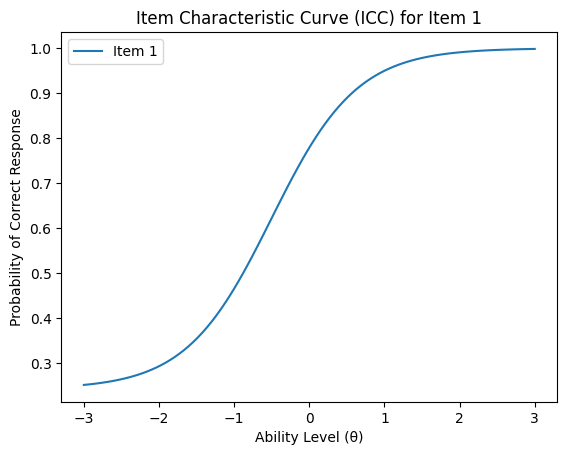

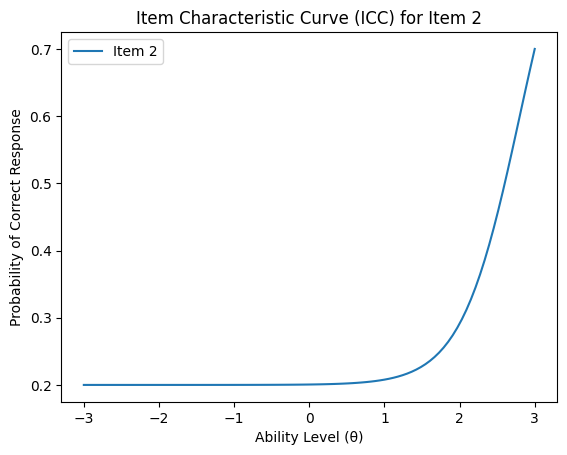

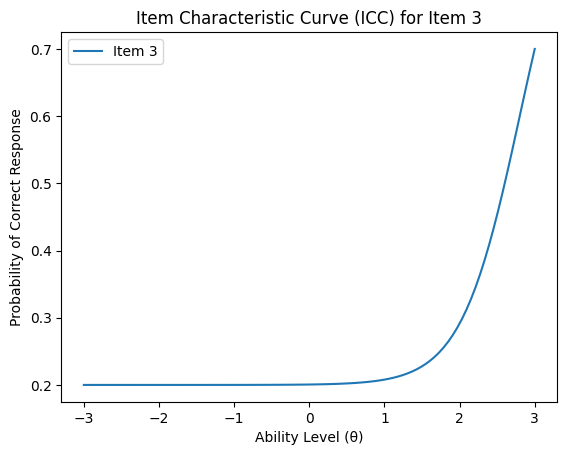

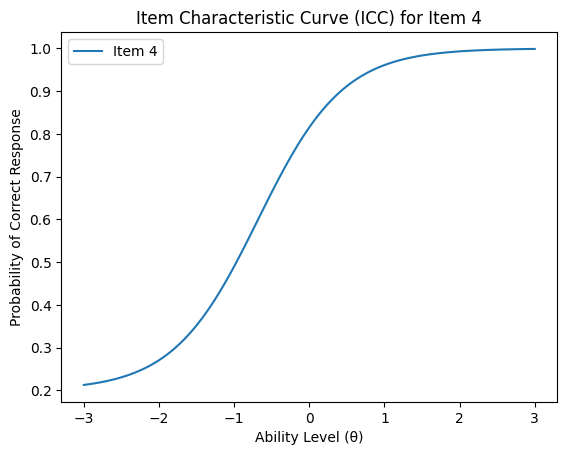

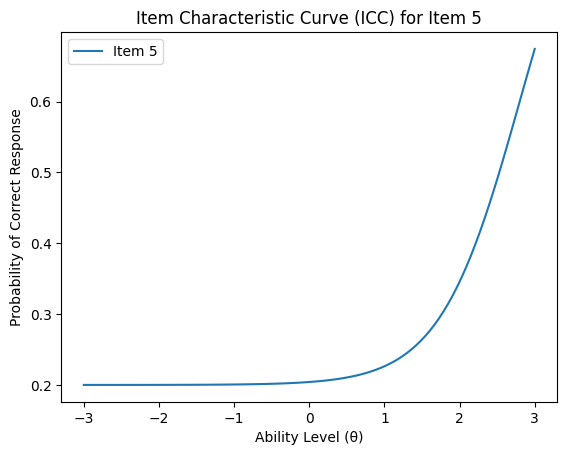

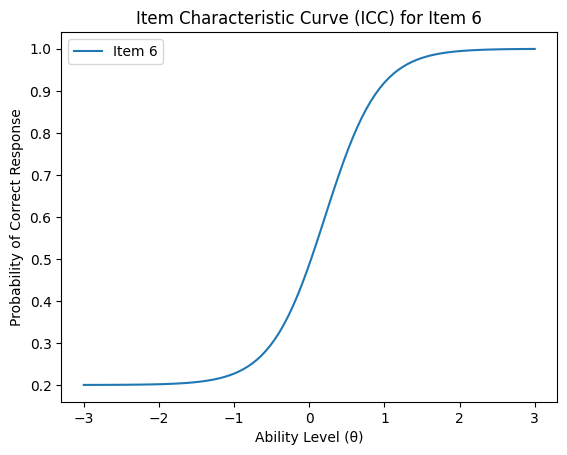

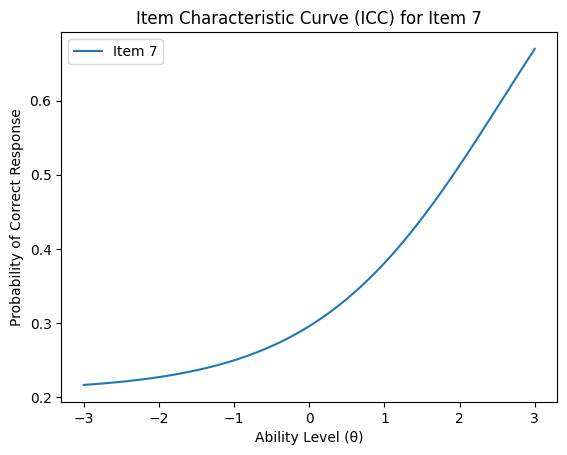

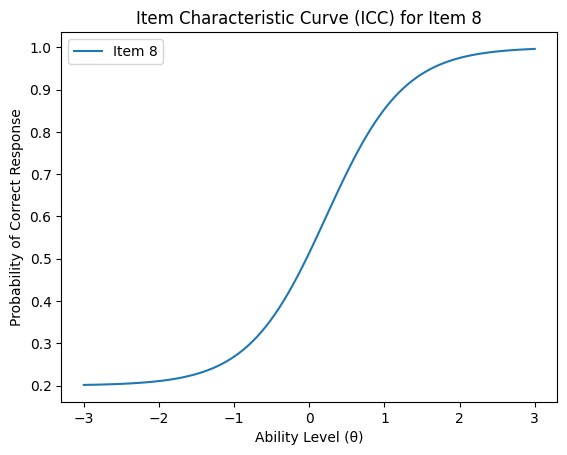

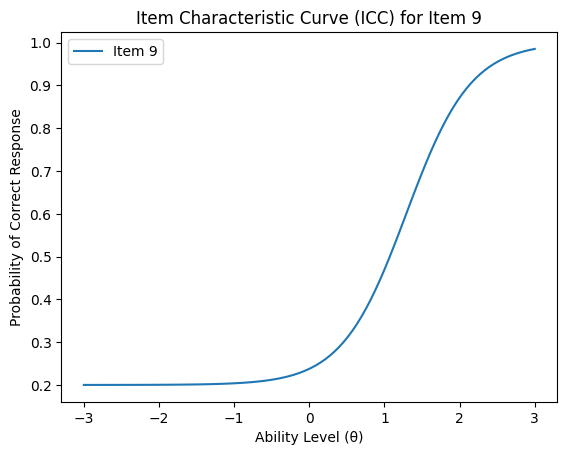

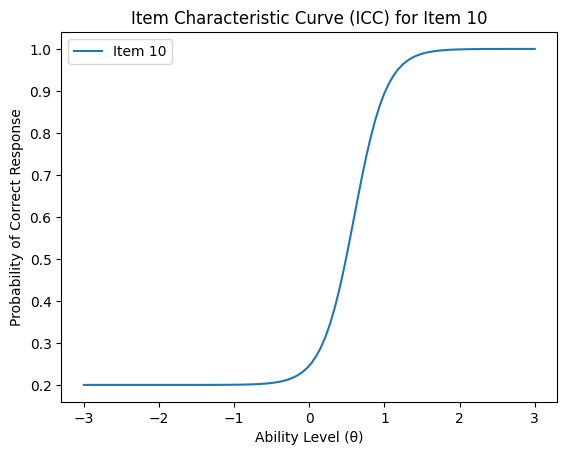

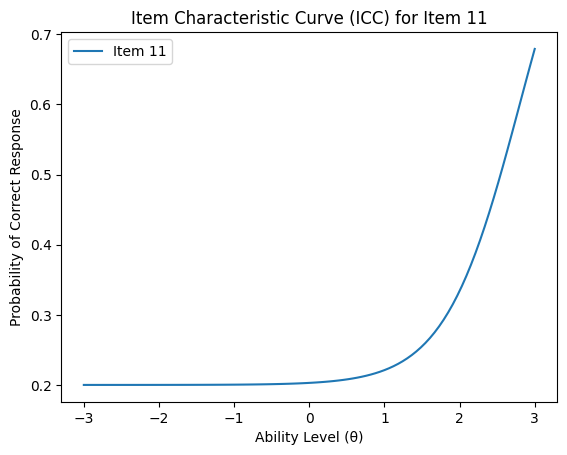

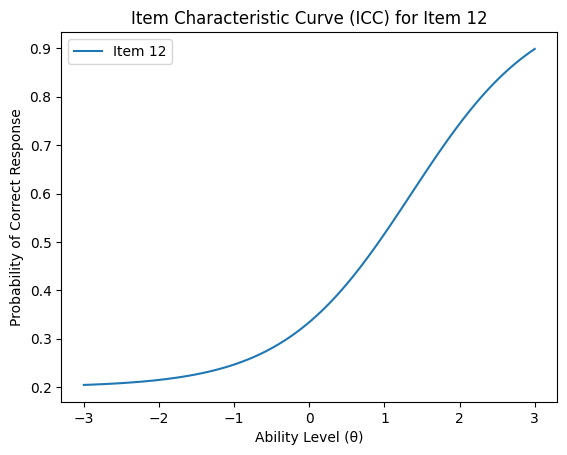

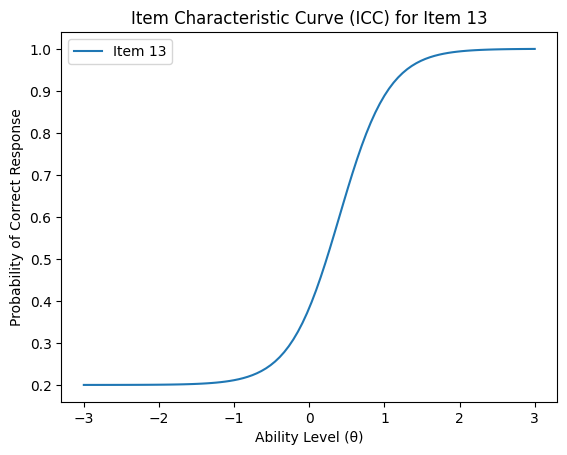

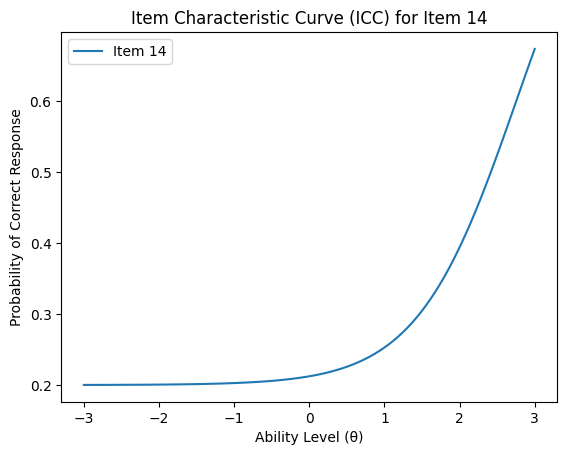

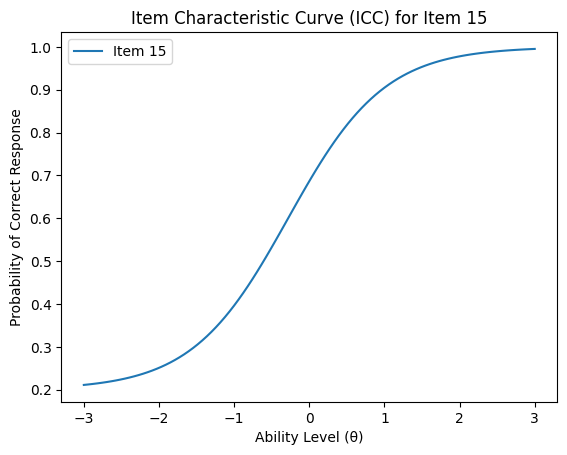

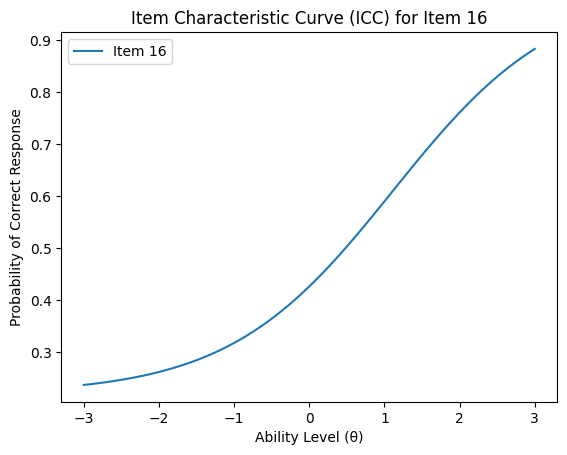

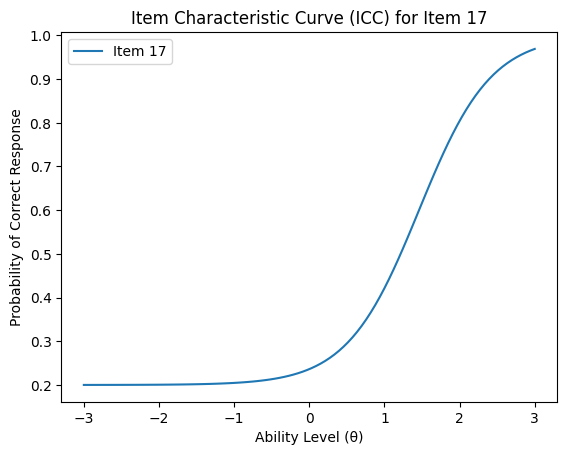

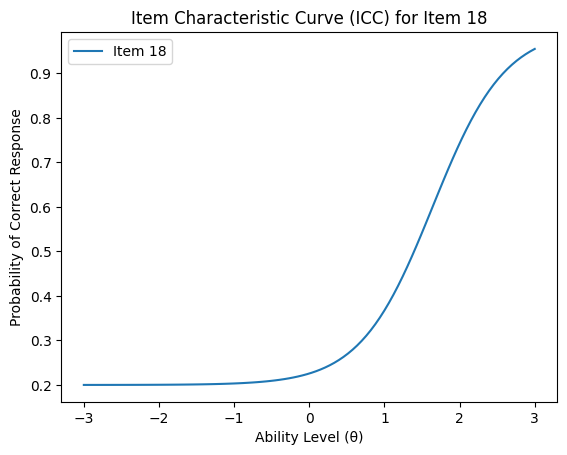

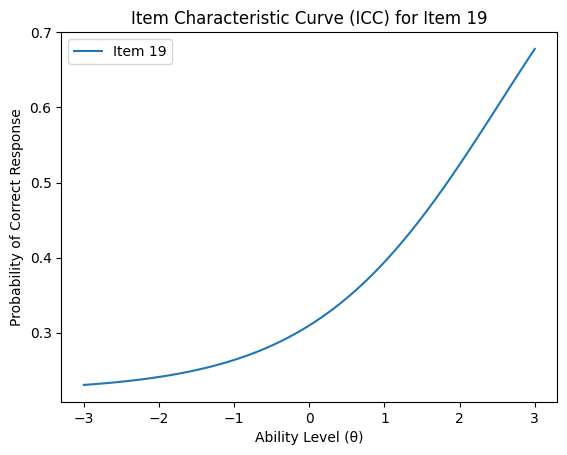

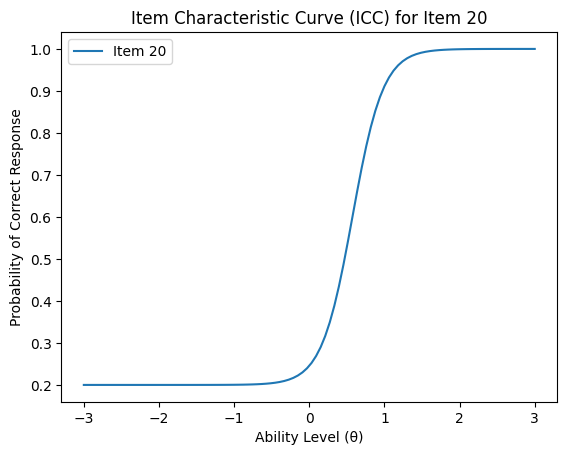

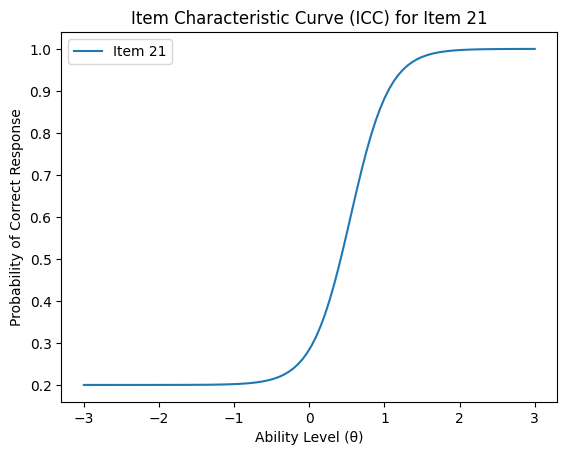

In [16]:
import matplotlib.pyplot as plt

theta_plot = np.linspace(-3, 3, 100)

# Use this theta_plot in the plotting code
for i, params in enumerate(item_parameters):
    a, b, c = params
    predicted_probabilities = three_pl_model(theta_plot, a, b, c)
    
    plt.plot(theta_plot, predicted_probabilities, label=f'Item {i+1}')
    plt.xlabel('Ability Level (θ)')
    plt.ylabel('Probability of Correct Response')
    plt.title(f'Item Characteristic Curve (ICC) for Item {i+1}')
    plt.legend()
    plt.show()


[1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1]
[array([ 1.75984453, -0.50372648,  0.24230344]), array([2.56270288, 2.8       , 0.2       ]), array([2.56028068, 2.8       , 0.2       ]), array([ 1.76824743, -0.68088321,  0.2       ]), array([1.87815068, 2.8       , 0.2       ]), array([2.7717274 , 0.20937546, 0.2       ]), array([0.80474661, 2.58337458, 0.20781457]), array([1.93310212, 0.2254694 , 0.2       ]), array([2.3301981 , 1.29050097, 0.2       ]), array([4.68510545, 0.59732312, 0.2       ]), array([2.00452841, 2.8       , 0.2       ]), array([1.17775909, 1.35882679, 0.2       ]), array([3.03251203, 0.39961858, 0.2       ]), array([1.50994817, 2.75512537, 0.2       ]), array([ 1.56210392, -0.28168611,  0.2       ]), array([0.91798045, 1.11132803, 0.21887059]), array([2.08733634, 1.46017626, 0.2       ]), array([2.0748306 , 1.64056666, 0.2       ]), array([0.80256317, 2.56533897, 0.22148975]), array([4.88642053, 0.57433576, 0.2       ]), array([3.89619477, 0.5492191 , 0.2       ])]
1

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



-6.725804148608566
1 2.330198104502583 1.2905009719875682 0.2 0.2311835747489061 6.164133525054469 -7.690888596952497
1 4.685105451019122 0.5973231166294004 0.2 0.23144430213811107 9.764898014519009 -11.595345025790067
1 2.0045284080319394 2.8 0.2 0.20245633195629958 11.363596953758602 -12.24414416706056
0 1.1777590932116278 1.358826791269735 0.2 0.3235341460776585 10.98255167125118 -12.547728206137908
0 3.0325120346631236 0.399618580879008 0.2 0.3496375720150014 9.922271526345293 -14.638846519997722
0 1.5099481690059309 2.755125365092695 0.2 0.21083393241791418 9.603923216126542 -15.018190321499523
1 1.5621039228535507 -0.2816861131235257 0.2 0.6609999524437828 10.133476520261649 -15.564980913328624
0 0.9179804535540383 1.1113280295773875 0.2188705859257283 0.4142257066109438 9.753225418233193 -15.769453091839273
0 2.0873363406325707 1.4601762637483375 0.2 0.23058568818486117 9.27191553165516 -16.54244950228158
0 2.074830600520357 1.6405666627932485 0.2 0.22169462186250793 8.811936746

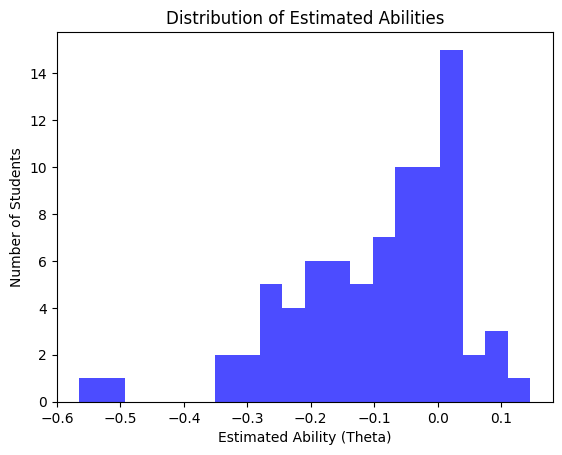

In [17]:
import numpy as np

# Function to compute the probability of a correct response given student's ability (theta)
def probability_correct(theta, a, b, c):
    """Calculate the probability of a correct response given ability (theta), discrimination (a), difficulty (b), and guessing (c)."""
    # Ensure stability by clamping the exponent within reasonable bounds
    exponent = np.clip(-a * (theta - b), -10, 10)
    return c + (1 - c) / (1 + np.exp(exponent))

# Function to estimate the ability (theta) using Maximum Likelihood Estimation (MLE)
def estimate_ability(response_vector, item_parameters, max_iterations=100, learning_rate=0.005, tolerance=1e-6):
    """Estimate the ability of a student using their response pattern and item parameters."""
    print(response_vector)
    print(item_parameters)
    
    theta = 0  # Start with an initial guess of ability
    i=0
    for _ in range(max_iterations):
        gradient = 0
        hessian = 0
        
        # Calculate gradient and hessian for each item response
        for response, (a, b, c) in zip(response_vector, item_parameters):
            p_correct = probability_correct(theta, a, b, c)
            gradient += (response - p_correct) * a
            hessian -= a * a * p_correct * (1 - p_correct)
            print(response, a, b, c, p_correct, gradient, hessian)
        
        # Update theta using gradient descent
        if abs(hessian) < tolerance:  # Prevent division by zero
            break
        theta_update = gradient / hessian
        # Clamp theta within a reasonable range to avoid divergence
        theta = np.clip(theta + learning_rate * theta_update, -5, 5)
        
        # Check for convergence
        if abs(theta_update) < tolerance:
            break
    
    return theta

# Estimating abilities for each student using the updated approach
student_abilities = [estimate_ability(student_responses, item_parameters) for student_responses in responses]
print("Estimated Abilities:", student_abilities)

# Plotting the distribution of estimated abilities
import matplotlib.pyplot as plt

plt.hist(student_abilities, bins=20, color='blue', alpha=0.7)
plt.xlabel('Estimated Ability (Theta)')
plt.ylabel('Number of Students')
plt.title('Distribution of Estimated Abilities')
plt.show()
